In [2]:
# Drive Check
! ls drive/MyDrive

'Colab Notebooks'   __init__.py   plant-data   __pycache__   yield_gen.py


In [3]:
from drive.MyDrive.yield_gen import *

In [4]:
import matplotlib.pyplot as plt

In [5]:
docs()



    * functions
        - generator() : arguments gen_type = ( with-aug | with-augmentation ) & host = ( local | colab )

    * usage 
    
        from yield_gen import * 
        train, valid, test = generator(gen_type="with-aug", host="colab") # returns a tf.generator object with data

    * requirements
    
        - local data directory structure
            ./plant-data
                /Train
                    /Train
                        ..samples
                /Test
                    /Test
                        ..samples 
                /Validation
                    /Validation
                        ..samples
        
        - Colab data directory structure 
            ./drive
                ./MyDrive
                    /plant-data
                        /Train
                            /Train
                                ..samples
                        /Test
                            /Test
                                ..samples 
             

In [6]:
# with augmentations
a_train, a_valid, a_test = generator("with-aug","colab")

Colab Paths Returned
Found 1322 images belonging to 3 classes.
Found 105 images belonging to 3 classes.
Found 105 images belonging to 3 classes.


In [7]:
# without augmentations
wa_train, wa_valid, wa_test = generator("without-aug",'colab')

Colab Paths Returned
Found 1322 images belonging to 3 classes.
Found 105 images belonging to 3 classes.
Found 105 images belonging to 3 classes.


In [8]:
# preview 
def plot_image(testx,testy,index):
    class_names = {'Healthy': 0, 'Powdery': 1, 'Rust': 2}
    plt.imshow(testx[index])
    plt.title(list(class_names.keys())[testy[index].argmax()])

In [9]:
testx, testy = next(a_train)

In [10]:
class_names = a_train.class_indices

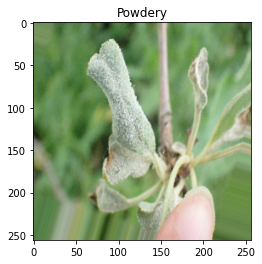

In [11]:
# with augmentations
plot_image(testx,testy, 1)

In [12]:

testx, testy = next(wa_train)

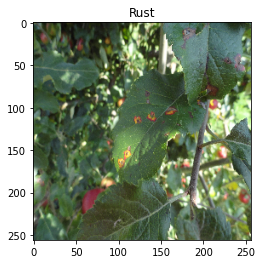

In [13]:
# without augmentations 
plot_image(testx,testy, 10)

## MobileNetV2

In [14]:
from tensorflow.keras.applications import MobileNetV2
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Activation, Dropout

In [15]:
# downloading network
conv_base = MobileNetV2(input_shape=a_train.image_shape, include_top=False, weights='imagenet')

In [16]:
conv_base.trainable

True

In [17]:
# freezing weights 
conv_base.trainable= False 

In [18]:
# mobileNet Summary
conv_base.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 128, 128, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [19]:
# custom output layer with mobilenetv2
model = Sequential()

model.add(conv_base)

model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dropout(0.4))

model.add(Dense(3,activation='softmax'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 8, 8, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 81920)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               10485888  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 12,744,259
Trainable params: 10,486,275
Non-trainable params: 2,257,984
_________________________________________________________________


In [21]:
# setting callbacks 
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(patience=3)

In [22]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [23]:
# Fitting Augmentated Generator
import time

start = time.perf_counter()

perf = model.fit_generator(a_train, epochs=15, callbacks=[early_stop],validation_data=a_valid)

elapsed = time.perf_counter()- start 

print('Elapsed {}'.format(elapsed/60))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
42/42 [==============================] - 663s 16s/step - loss: 5.5250 - accuracy: 0.7549 - val_loss: 0.3107 - val_accuracy: 0.9048
Epoch 2/15
42/42 [==============================] - 204s 5s/step - loss: 0.2029 - accuracy: 0.9191 - val_loss: 0.3016 - val_accuracy: 0.9333
Epoch 3/15
42/42 [==============================] - 204s 5s/step - loss: 0.1596 - accuracy: 0.9478 - val_loss: 0.3565 - val_accuracy: 0.8952
Epoch 4/15
42/42 [==============================] - 203s 5s/step - loss: 0.1718 - accuracy: 0.9455 - val_loss: 0.1453 - val_accuracy: 0.9619
Epoch 5/15
42/42 [==============================] - 204s 5s/step - loss: 0.1468 - accuracy: 0.9501 - val_loss: 0.1696 - val_accuracy: 0.9619
Epoch 6/15
42/42 [==============================] - 203s 5s/step - loss: 0.1083 - accuracy: 0.9682 - val_loss: 0.2754 - val_accuracy: 0.9429
Epoch 7/15
42/42 [==============================] - 201s 5s/step - loss: 0.1392 - accuracy: 0.9501 - val_loss: 0.1119 - val_accuracy: 0.9714
Epoch 8/15
4

In [24]:
# saving model
model.save("MobileNetV2.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [25]:
import pandas as pd 

In [28]:
histdata = pd.DataFrame(perf.history)

In [29]:
histdata

,loss,accuracy,val_loss,val_accuracy
0,5.525011,0.754917,0.310750,0.904762
1,0.202897,0.919062,0.301585,0.933333
2,0.159576,0.947806,0.356519,0.895238
3,0.171820,0.945537,0.145255,0.961905
4,0.146838,0.950076,0.169560,0.961905
5,0.108341,0.968230,0.275420,0.942857
6,0.139172,0.950076,0.111914,0.971429
7,0.118453,0.960666,0.450717,0.942857
8,0.108631,0.962935,0.308468,0.961905
9,0.143767,0.951589,0.197198,0.923810


In [30]:
# evaluating validation
new_loss, new_acc = model.evaluate_generator(a_valid)
print('Validation Accuracy - {:.2f}%'.format(new_acc*100))
print('validation loss - {:.2f}'.format(new_loss))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Validation Accuracy - 92.38%
validation loss - 0.27


In [31]:
# evaluating test
test_loss, test_acc = model.evaluate_generator(a_test)
print('Test Accuracy - {:.2f}%'.format(test_acc*100))
print('Test loss - {:.2f}'.format(test_loss))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Test Accuracy - 93.33%
Test loss - 0.26


In [41]:
histdata.iloc[-1:,:].values[0][:2]

array([0.14376713, 0.95158851])

In [32]:
histdata.to_csv("MobileNetV2stats.csv")

In [46]:
content = """

Model - {}

* Train Accuracy - {:.2f}%
* Train loss - {:.2f}

* Validation Accuracy - {:.2f}%
* validation loss - {:.2f}

* Test Accuracy - {:.2f}%
* Test loss - {:.2f}

Elapsed - {} Mins

""".format('MobileNetV2',histdata.iloc[-1:,:].values[0][:2][0],histdata.iloc[-1:,:].values[0][:2][1],(new_acc*100),new_loss, (test_acc*100), test_loss, elapsed//60)


print(content)

# with open("summarised-metrics.txt","w") as f:
  



Model - MobileNetV2

* Train Accuracy - 0.14%
* Train loss - 0.95

* Validation Accuracy - 92.38%
* validation loss - 0.27

* Test Accuracy - 93.33%
* Test loss - 0.26

Elapsed - 41.0 Mins




In [ ]:
import matplotlib.pyplot as plt 

In [47]:
history = histdata

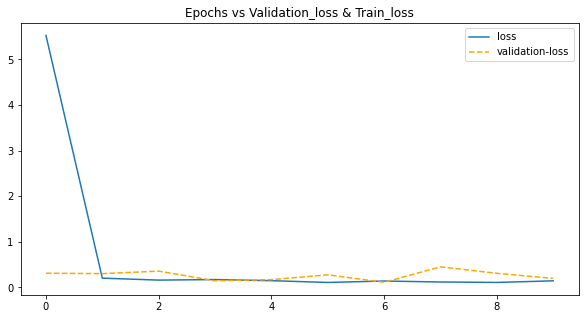

In [48]:
plt.figure(figsize=(10,5))
plt.plot(history['loss'],label='loss')
plt.plot(history['val_loss'],ls='--',color='orange',label='validation-loss')
plt.title('Epochs vs Validation_loss & Train_loss')
plt.legend()

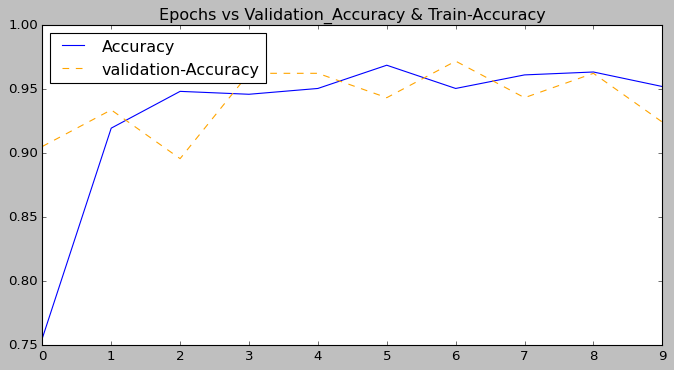

In [50]:
plt.figure(figsize=(10,5))
plt.plot(history['accuracy'],label='Accuracy')
plt.plot(history['val_accuracy'],ls='--',color='orange',label='validation-Accuracy')
plt.title('Epochs vs Validation_Accuracy & Train-Accuracy')
plt.legend(loc='upper left')


In [59]:
# evaluation pipeline
import tensorflow as tf 
import matplotlib.pyplot as plt 
plt.style.use("classic")
from tensorflow.keras.models import load_model
from zipfile import ZipFile


def evaluate_model(modelname,model, valid, test, history, elapsed):


  # zipobj
  zipobj = ZipFile('{}.zip'.format(modelname), 'w')

  # evaluating validation
  new_loss, new_acc = model.evaluate_generator(valid)
  print('Validation Accuracy - {:.2f}%'.format(new_acc*100))
  print('validation loss - {:.2f}'.format(new_loss))

  # evaluating test 
  test_loss, test_acc = model.evaluate_generator(test)
  print('Test Accuracy - {:.2f}%'.format(test_acc*100))
  print('Test loss - {:.2f}'.format(test_loss))


  # Plotting - LOSS
  plt.figure(figsize=(10,5))
  plt.plot(history['loss'],label='loss')
  plt.plot(history['val_loss'],ls='--',color='orange',label='validation-loss')
  plt.title('Epochs vs Validation_loss & Train_loss')
  plt.legend()
  plt.savefig("loss_valloss-{}.png".format(modelname))
  zipobj.write("loss_valloss-{}.png".format(modelname))

  # Plotting - Accuracy

  plt.figure(figsize=(10,5))
  plt.plot(history['accuracy'],label='Accuracy')
  plt.plot(history['val_accuracy'],ls='--',color='orange',label='validation-Accuracy')
  plt.title('Epochs vs Validation_Accuracy & Train-Accuracy')
  plt.legend(loc='upper left')
  plt.savefig("acc-valacc-{}.png".format(modelname))
  zipobj.write("acc-valacc-{}.png".format(modelname))


  history.to_csv("{}-stats.csv".format(modelname))
  zipobj.write("{}-stats.csv".format(modelname))

  # writing content

  content = """

Model - {}

* Train Accuracy - {:.2f}%
* Train loss - {:.2f}

* Validation Accuracy - {:.2f}%
* validation loss - {:.2f}

* Test Accuracy - {:.2f}%
* Test loss - {:.2f}

Elapsed - {} Mins

""".format('MobileNetV2',history.iloc[-1:,:].values[0][:2][0],history.iloc[-1:,:].values[0][:2][1],(new_acc*100),new_loss, (test_acc*100), test_loss, elapsed//60)


  with open("{}-summary.txt".format(modelname), "w") as f:
    f.write(content)

  zipobj.write("{}-summary.txt".format(modelname))

  print("preserving records")
  model.save("{}.h5".format(modelname))
  zipobj.write("{}.h5".format(modelname))

  print("{} Records Created".format(modelname))

  

  zipobj.close()
     


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Validation Accuracy - 95.24%
validation loss - 0.23
Test Accuracy - 97.14%
Test loss - 0.19
preserving records


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


MobileNetV2 Records Created


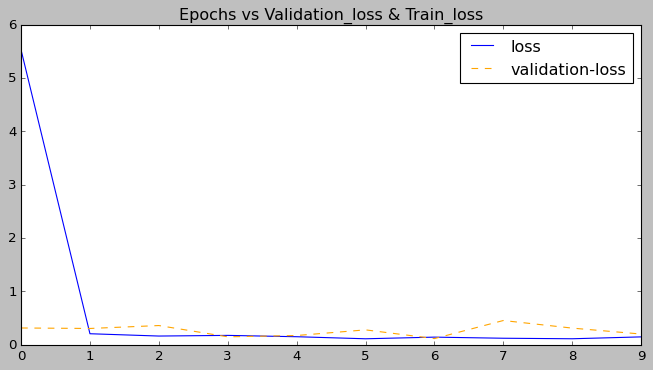

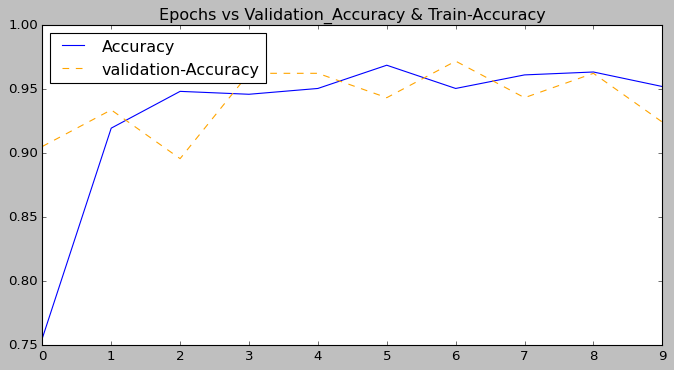

In [60]:
evaluate_model("MobileNetV2", model, a_valid, a_test, histdata, elapsed)